In [1]:
import os, copy, pickle, torch, torchvision, types
import types
from torch import Tensor
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset, random_split

import numpy as np
from tqdm import tqdm

from utils import AverageMeter, accuracy, save_checkpoint, plot_train_progress, get_model
from loss import LossComputer

from data.dro_dataset import get_loader

In [2]:
# from IPython.display import display, HTML
# display(HTML("<style>.container { width:100% !important; }</style>"))
! gpustat

know-distill              Sat Aug 12 16:19:05 2023  510.47.03
[0] NVIDIA A100-SXM4-40GB | 31°C,  27 % |   605 / 40960 MB |


In [3]:
from typing import Any, Callable, List, Optional, Type, Union
def conv3x3(in_planes: int, out_planes: int, stride: int = 1, groups: int = 1, dilation: int = 1) -> nn.Conv2d:
    """3x3 convolution with padding"""
    return nn.Conv2d(
        in_planes,
        out_planes,
        kernel_size=3,
        stride=stride,
        padding=dilation,
        groups=groups,
        bias=False,
        dilation=dilation,
    )

class BasicBlock(nn.Module):
    expansion: int = 1

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError("BasicBlock only supports groups=1 and base_width=64")
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        return out

class FeatResNet(nn.Module):
    
    def __init__(self, core_resnet, level):
        super(FeatResNet, self).__init__()
        self.internal = core_resnet
        self.level = level
    
    def forward(self, x: Tensor) -> Tensor:
        x = self.internal.conv1(x)
        x = self.internal.bn1(x)
        x = self.internal.relu(x)
        x = self.internal.maxpool(x)

        x = self.internal.layer1(x)
        if self.level == 1: return x
        
        x = self.internal.layer2(x)
        if self.level == 2: return x
        
        x = self.internal.layer3(x)
        if self.level == 3: return x
        
        x = self.internal.layer4(x)
        if self.level == 4: return x

        x = self.internal.avgpool(x)
        x = torch.flatten(x, 1)
        ft = x
        x = self.internal.fc(x)

        return x

class Projector(nn.Module):
    def __init__(self, d, conv_block=None):
        super(Projector, self).__init__()
        self.block = conv_block
        self.fc = nn.Linear(d, 2)

    def forward(self, x):
        if self.block != None:
            x = self.block(x)
        x = torch.flatten(nn.AdaptiveAvgPool2d((1, 1))(x), 1)
        x = self.fc(x)
        return x

In [4]:
# train
def train(model, projector, optimizer, train_loader, num_epochs=8):
    criterion = nn.CrossEntropyLoss(reduction='none')
    model.eval()
    projector.train()
    for epoch in range(num_epochs):
#         print(epoch)
        for batch_idx, batch in enumerate(train_loader):
            x = batch[0].to(device='cuda')
            y = batch[1].to(device='cuda')
            yhat = projector(model(x))
            loss = criterion(yhat, y).mean()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

def infer(model, projector, test_loader):
    model.eval()
    projector.eval()
    
    outputs = []
    targets = []
    groups = []
    margins = []
    
    with torch.no_grad():
        for batch_idx, batch in enumerate(test_loader):
            x = batch[0].to(device='cuda')
            y = batch[1]
            g = batch[2]
            yhat = torch.softmax(projector(model(x)), dim=1).to(device='cpu')
            output = torch.argmax(yhat, dim=1)
            
            outputs.append(output)
            targets.append(y)
            groups.append(g)
            margins.append(torch.abs(yhat[:, 0] - yhat[:, 1]))
    
    outputs = torch.cat(outputs, dim=0)
    targets = torch.cat(targets, dim=0)
    groups = torch.cat(groups, dim=0)
    margins = torch.cat(margins, dim=0)
    
    return outputs, targets, groups, margins

In [5]:
def get_margin_details(dataset, epoch=1, feature_level=1, basic_block=True, train_test_split=False):
    torch.manual_seed(0)
    if dataset == 'CelebA':
        widx, minority = 3, 2
        learning_rate = 1e-4
        epochs = 1
        pkl_name = 'Blond_Hair_Male_dataset_0.pkl'
    else: # could be named waterbirds
        dataset = 'CUB'
        widx, minority = 2, 1
        learning_rate = 1e-3
        epochs = 1 # change
        pkl_name = 'waterbird_complete95_forest2water2_dataset_0.pkl'
    
    with open(os.path.join('results', dataset, pkl_name), 'rb') as file:
        data = pickle.load(file)
        train_data = data['train_data']
    loader_kwargs = {'batch_size':128, 'num_workers':4, 'pin_memory':True}
    n = len(train_data)
    if train_test_split:
        train_data, test_data = random_split(train_data, [n//2, n-n//2])
    else:
        test_data = train_data
    train_loader, test_loader = get_loader(train_data, train=True, **loader_kwargs), get_loader(test_data, train=False, **loader_kwargs)
    
    model = get_model('resnet18')
    d = model.fc.in_features
    model.fc = nn.Linear(d, 2)
    model_ckpt = torch.load(os.path.join(f'./results/{dataset}/resnet18-pt_0/', f'{epoch}_ckpt.pth.tar'))
    model.load_state_dict(model_ckpt['model'])
        
    model = model.to(device='cuda')
    for _, param in model.named_parameters():
        param.requires_grad = False
    model = FeatResNet(model, feature_level).to(device='cuda')
    
    samples = next(iter(train_loader))
    sample_inputs = samples[0].to(device='cuda')
    
    if basic_block:
        converter = BasicBlock(32 * 2**feature_level, 64 * 2**feature_level, stride=1).to(device='cuda')
        features = converter(model(sample_inputs))
        d = torch.flatten(nn.AdaptiveAvgPool2d((1, 1))(features), 1).shape[1]
        projector = Projector(d, converter).to(device='cuda')
    else:
        features = model(sample_inputs)
        d = torch.flatten(nn.AdaptiveAvgPool2d((1, 1))(features), 1).shape[1]
        projector = Projector(d).to(device='cuda')
    
    optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, projector.parameters()), 
                                lr=learning_rate, momentum=0.9, weight_decay=5e-4)
    train(model, projector, optimizer, train_loader, num_epochs=epochs)

    outputs, targets, groups, margins = infer(model, projector, test_loader)
    return outputs.cpu(), targets.cpu(), groups.cpu(), margins.cpu()
    

In [54]:
from sklearn.metrics import roc_auc_score

def metrics(outputs, targets, groups, margins, dataset):
    
    if dataset == 'waterbirds':
        widx, minority = 2, 1
    elif dataset == 'CelebA':
        widx, minority = 3, 2
    outputs, targets, groups = outputs.numpy(), targets.numpy(), groups.numpy()
    pred_wrong = outputs != targets
    matched_worst = (groups == widx)
    matched_conflict = (matched_worst | groups == minority)
    
    true_positives = np.logical_and(pred_wrong, matched_worst).sum()
    false_positives = np.logical_and(pred_wrong, ~matched_worst).sum()
    false_negatives = np.logical_and(~pred_wrong, matched_worst).sum()

    precision = true_positives / (true_positives + false_positives)
    recall = true_positives / (true_positives + false_negatives)
    
    margins[~pred_wrong] = 0
    worst_auc = roc_auc_score(matched_worst.astype(int), margins)
    conflict_auc = roc_auc_score(matched_conflict.astype(int), margins)
    
    return precision, recall, worst_auc, conflict_auc
    
    

In [56]:
dataset, epoch = 'waterbirds', 1
precs, recs, w_aucs, c_aucs = [], [], [], []
levels = list(range(1, 5)) 
for feature_level in levels:
    args = dataset, epoch, feature_level
    result = get_margin_details(*args)
    prec, rec, w_auc, c_auc = metrics(*result, dataset)
    precs.append(prec)
    recs.append(rec)
    w_aucs.append(w_auc)
    c_aucs.append(c_auc)

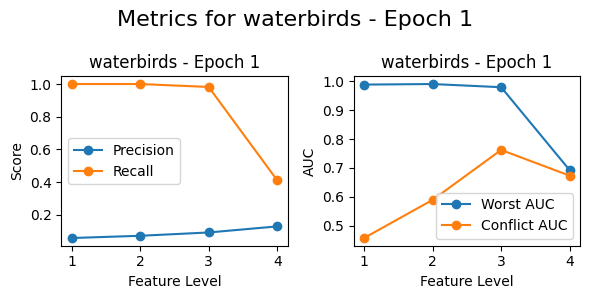

In [57]:
fig, axs = plt.subplots(1, 2, figsize=(6, 3))

axs[0].plot(levels, precs, label='Precision', marker='o')
axs[0].plot(levels, recs, label='Recall', marker='o')
axs[0].set_xlabel('Feature Level')
axs[0].set_ylabel('Score')
axs[0].set_title(f'{dataset} - Epoch {epoch}')
axs[0].legend()
axs[0].set_xticks(levels) 

axs[1].plot(levels, w_aucs, label='Worst AUC', marker='o')
axs[1].plot(levels, c_aucs, label='Conflict AUC', marker='o')
axs[1].set_xlabel('Feature Level')
axs[1].set_ylabel('AUC')
axs[1].set_title(f'{dataset} - Epoch {epoch}')
axs[1].legend()
axs[1].set_xticks(levels) 

plt.suptitle(f'Metrics for {dataset} - Epoch {epoch}', fontsize=16)
plt.tight_layout()
plt.show()

In [58]:
dataset, epoch = 'CelebA', 1
precs, recs, w_aucs, c_aucs = [], [], [], []
levels = list(range(1, 5)) 
for feature_level in levels:
    args = dataset, epoch, feature_level
    result = get_margin_details(*args)
    prec, rec, w_auc, c_auc = metrics(*result, dataset)
    precs.append(prec)
    recs.append(rec)
    w_aucs.append(w_auc)
    c_aucs.append(c_auc)

OSError: [Errno 12] Cannot allocate memory

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(6, 3))

axs[0].plot(levels, precs, label='Precision', marker='o')
axs[0].plot(levels, recs, label='Recall', marker='o')
axs[0].set_xlabel('Feature Level')
axs[0].set_ylabel('Score')
axs[0].set_title(f'{dataset} - Epoch {epoch}')
axs[0].legend()
axs[0].set_xticks(levels) 

axs[1].plot(levels, w_aucs, label='Worst AUC', marker='o')
axs[1].plot(levels, c_aucs, label='Conflict AUC', marker='o')
axs[1].set_xlabel('Feature Level')
axs[1].set_ylabel('AUC')
axs[1].set_title(f'{dataset} - Epoch {epoch}')
axs[1].legend()
axs[1].set_xticks(levels) 

plt.suptitle(f'Metrics for {dataset} - Epoch {epoch}', fontsize=16)
plt.tight_layout()
plt.show()

In [39]:
def plot(outputs, targets, groups, margins, dataset, epoch, feature_level=1):
    if dataset == 'waterbirds':
        widx, minority = 2, 1
    elif dataset == 'CelebA':
        widx, minority = 3, 2
    majority = []
    outputs, targets, groups, margins = outputs.numpy(), targets.numpy(), groups.numpy(), margins.numpy()
#     print(np.unique(groups))
    pred_right = outputs == targets
    correct, wrong = {}, {}
    for group in range(4):
        if group not in [widx, minority]: majority.append(group)
        correct[group] = margins[pred_right & (groups == group)]
        wrong[group] = margins[~pred_right & (groups == group)]
        print(f"group {group}, correct {len(correct[group])}, wrong {len(wrong[group])}")
    correct["worst"] = correct[widx]
    wrong["worst"] = wrong[widx]
    correct["rest"] = margins[pred_right & (groups != widx)]
    wrong["rest"] = margins[~pred_right & (groups != widx)]
    
    print(f'recall: {100 * len(wrong["worst"]) / (len(correct["worst"])+len(wrong["worst"])):.2f}')
    
    num_bins = 10
    fig, axs = plt.subplots(1, 4, figsize=(12, 4))
    # Plot the histogram
    
    #non-worst right
    _, c_rest_edges = np.histogram(correct["rest"], bins=num_bins, range=(0, 1))
    axs[0].hist(correct["rest"], bins=c_rest_edges, color='blue', alpha=0.7)
    axs[0].set_title('Pred non-worst right, count:{}'.format(len(correct["rest"])))
    #worst right
    _, c_worst_edges = np.histogram(correct["worst"], bins=num_bins, range=(0, 1))
    axs[1].hist(correct["worst"], bins=c_worst_edges, color='red', alpha=0.7)
    axs[1].set_title('Pred worst right, count:{}'.format(len(correct["worst"])))
    #non-worst wrong
    _, w_rest_edges = np.histogram(wrong["rest"], bins=num_bins, range=(0, 1))
    axs[2].hist(wrong["rest"], bins=w_rest_edges, color='green', alpha=0.7)
    axs[2].set_title('Pred non-worst wrong, count:{}'.format(len(wrong["rest"])))
    #worst wrong
    _, w_worst_edges = np.histogram(wrong["rest"], bins=num_bins, range=(0, 1))
    axs[3].hist(wrong["worst"], bins=w_worst_edges, color='purple', alpha=0.7)
    axs[3].set_title('Pred worst wrong, count:{}'.format(len(wrong["worst"])))
    
    
    fig.suptitle(f"{dataset}, {epoch} epoch ckpt, aux trained after {feature_level} stage, "
             f"Acc on worst group (index={widx}): "
             f"{100*len(correct['worst']) / (len(correct['worst']) + len(wrong['worst'])):.2f}, "
             f"non-worst: {100*len(correct['rest']) / (len(correct['rest']) + len(wrong['rest'])):.2f}", 
             fontsize=16)

    for ax in axs.flat:
        ax.set_xlabel('Margin (confidence)')
        ax.set_ylabel('Distribution')
        ax.grid(True)
        ax.legend()
    
    plt.tight_layout()
    plt.show()
    
    
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    num_bins = 20
    i = 0
    color_map = {majority[0]: 'darkgreen', majority[1]: 'limegreen', minority:'orange', widx:'red'}
    name_map = {majority[0]: f'Major grp {majority[0]}', 
                majority[1]: f'Major grp {majority[1]}', 
                minority: f'Conflicting non-worst grp {minority}',
                widx: f'Conflicting worst grp {widx}',}
    print("majority", majority)
    print("conflict, worst", [minority, widx])
    
    for g in range(4):
        _, correct_edges = np.histogram(correct[g], bins=num_bins, range=(0, 1))
        mean, std, size = np.mean(correct[g]), np.std(correct[g]), len(correct[g])
        hist, _ = np.histogram(correct[g], bins=correct_edges, range=(0, 1))
        hist = hist / np.sum(hist)
        axs[0].hist(correct[g], bins=correct_edges, color=color_map[g], alpha=0.7, density=True,
                 label=f'#{size} {name_map[g]}, (distn {mean:.2f}+/-{std:.2f})')
        axs[0].set_title(f'Correct pred distribution, {dataset}')
        
        _, wrong_edges = np.histogram(wrong[g], bins=num_bins, range=(0, 1))
        mean, std, size = np.mean(wrong[g]), np.std(wrong[g]), len(wrong[g])
        hist, _ = np.histogram(wrong[g], bins=wrong_edges, range=(0, 1))
        hist = hist / np.sum(hist)
        axs[1].hist(wrong[g], bins=wrong_edges, color=color_map[g], alpha=0.7, density=True,
                 label=f'#{size} {name_map[g]}, (distn {mean:.2f}+/-{std:.2f})')
        axs[1].set_title(f'Wrong pred distribution, {dataset}')

    for ax in axs.flat:
        ax.set_xlabel('Margin (confidence)')
        ax.set_ylabel('Distribution')
        ax.grid(True)
        ax.legend()
    
    plt.tight_layout()
    plt.show()


In [7]:
def plot_dataset(dataset, epoch, feature_level):
    plot(*get_margin_details(dataset, epoch=epoch, feature_level=feature_level), 
     dataset, epoch=epoch, feature_level=feature_level)

In [ ]:
dataset, epoch, feature_level = 'waterbirds', 1, 1
args = dataset, epoch, feature_level
result = get_margin_details(*args)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


group 0, correct 3495, wrong 3
group 1, correct 158, wrong 26
group 2, correct 0, wrong 56
group 3, correct 166, wrong 891
recall: 100.00


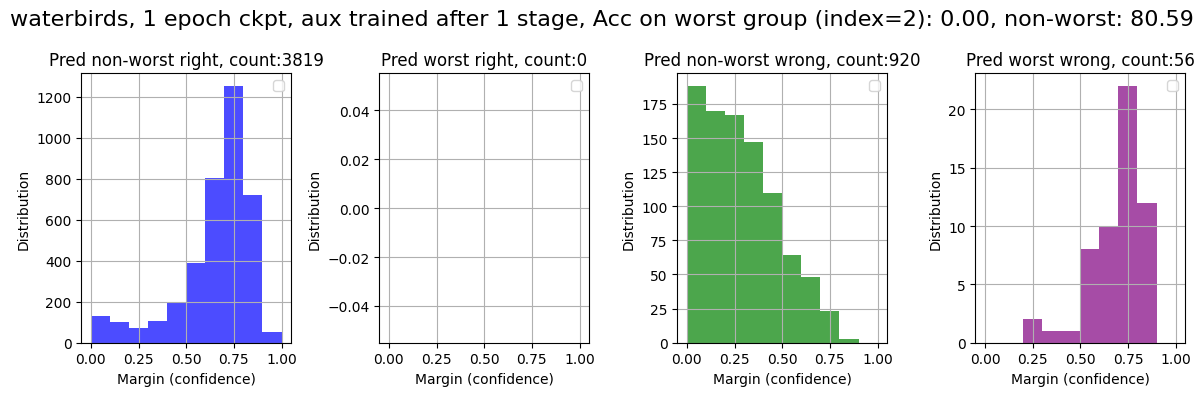

majority [0, 3]
conflict, worst [1, 2]


/home/anmolreddy/.local/lib/python3.7/site-packages/ipykernel_launcher.py:77: RuntimeWarning: invalid value encountered in true_divide


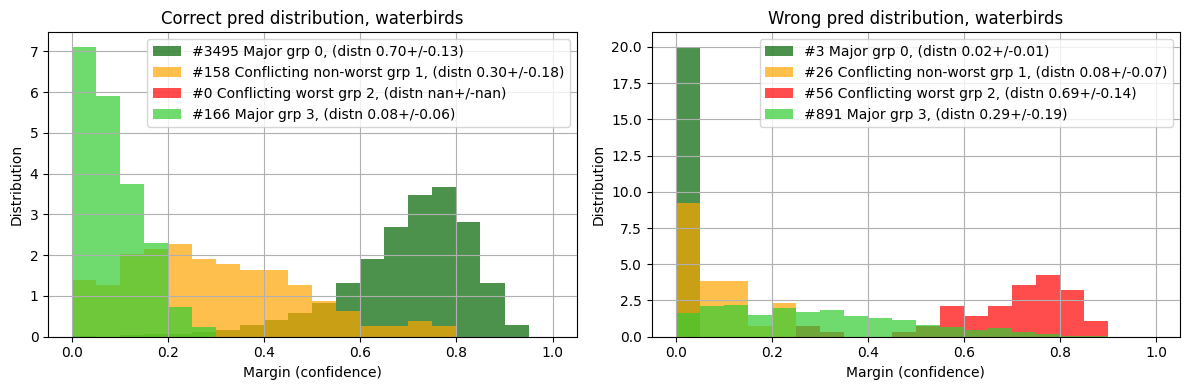

In [21]:
plot(*result, *args)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


group 0, correct 3465, wrong 33
group 1, correct 116, wrong 68
group 2, correct 33, wrong 23
group 3, correct 1002, wrong 55
recall: 41.07


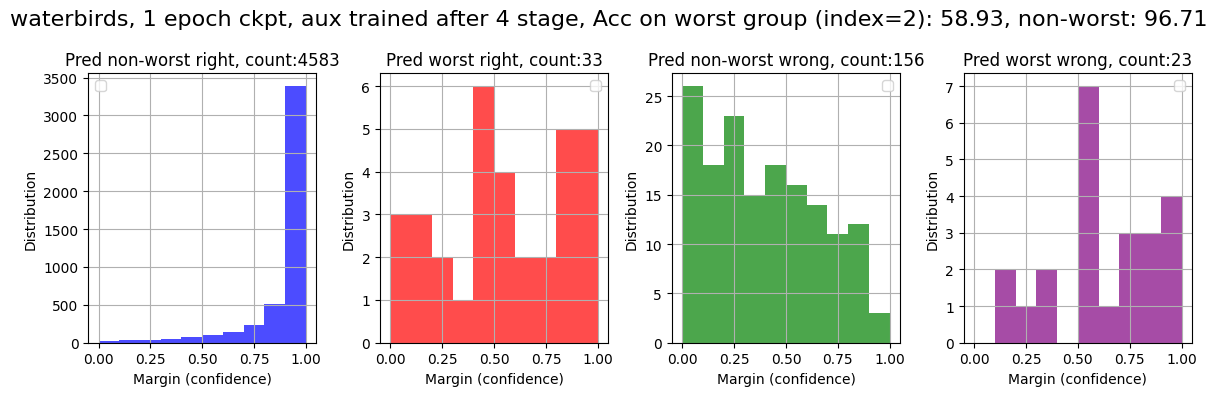

majority [0, 3]
conflict, worst [1, 2]


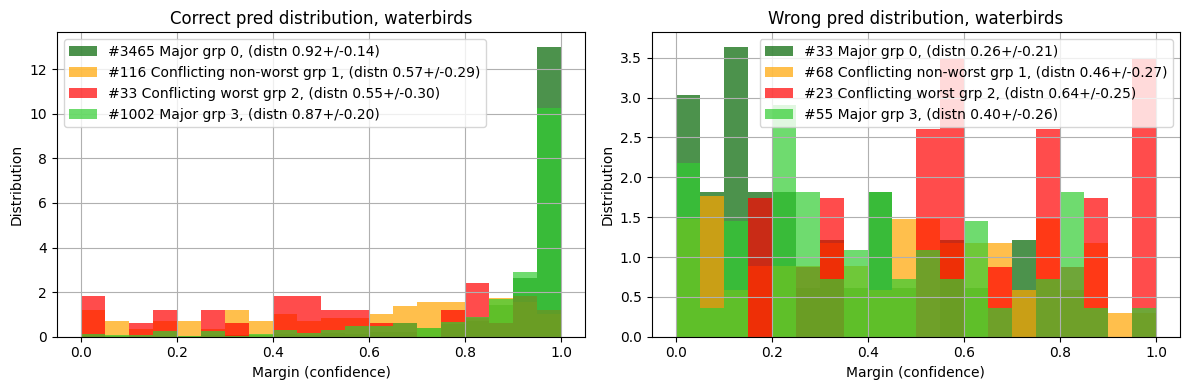

In [22]:
plot_dataset('waterbirds', epoch=1, feature_level=4)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


group 0, correct 3495, wrong 3
group 1, correct 161, wrong 23
group 2, correct 0, wrong 56
group 3, correct 173, wrong 884
recall: 100.00


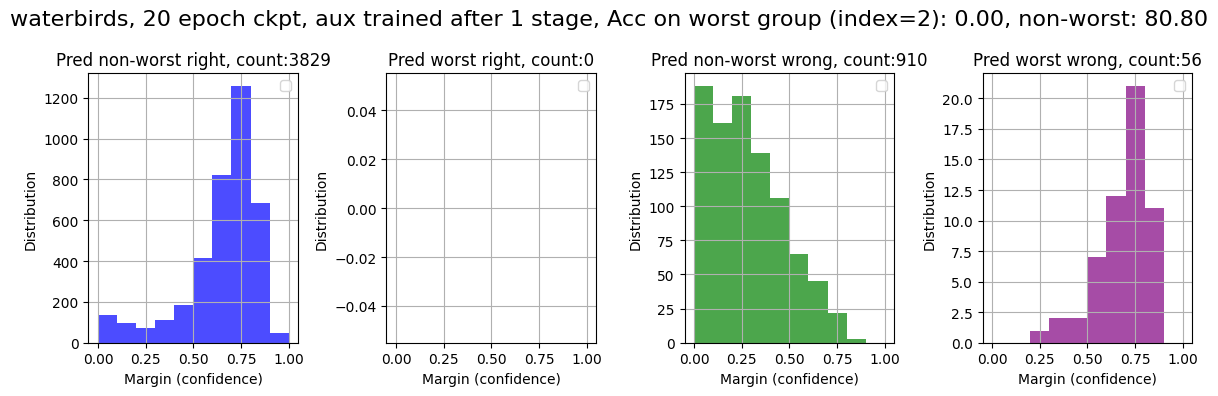

majority [0, 3]
conflict, worst [1, 2]


/home/anmolreddy/.local/lib/python3.7/site-packages/ipykernel_launcher.py:77: RuntimeWarning: invalid value encountered in true_divide


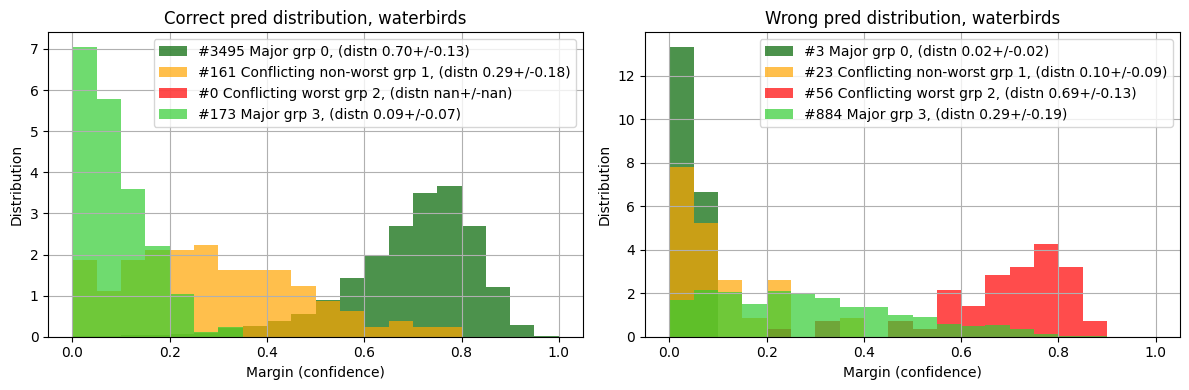

In [23]:
plot_dataset('waterbirds', epoch=20, feature_level=1)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


group 0, correct 3498, wrong 0
group 1, correct 184, wrong 0
group 2, correct 56, wrong 0
group 3, correct 1057, wrong 0
recall: 0.00


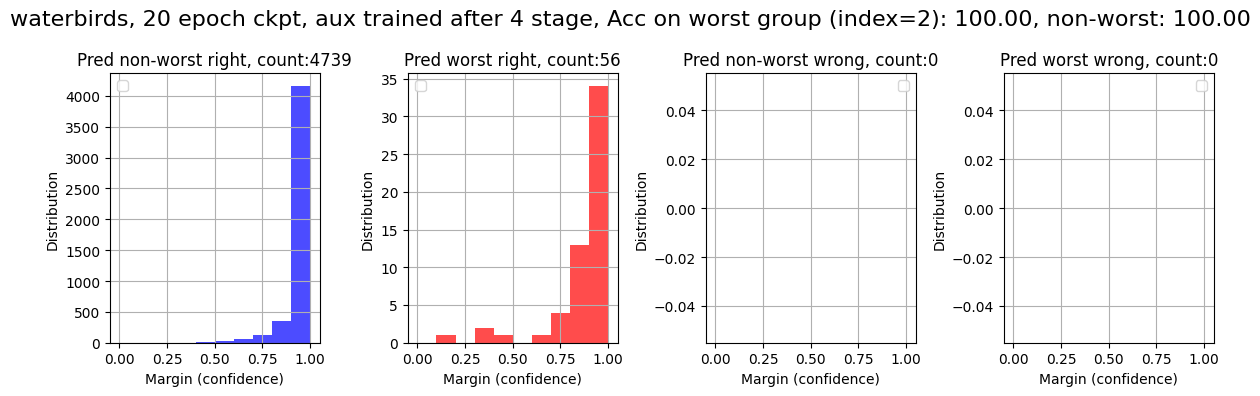

majority [0, 3]
conflict, worst [1, 2]


/home/anmolreddy/.local/lib/python3.7/site-packages/ipykernel_launcher.py:85: RuntimeWarning: invalid value encountered in true_divide


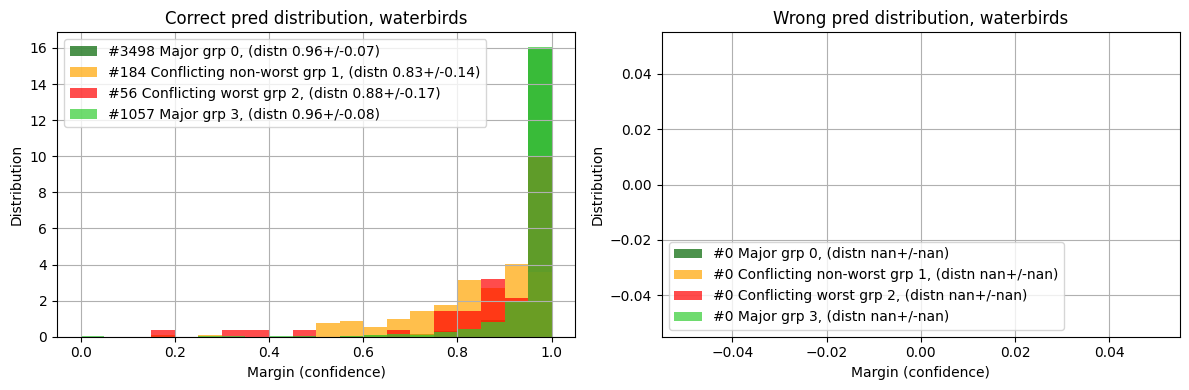

In [24]:
plot_dataset('waterbirds', epoch=20, feature_level=4)

group 0, correct 3497, wrong 1
group 1, correct 163, wrong 21
group 2, correct 0, wrong 56
group 3, correct 156, wrong 901
recall: 100.00


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


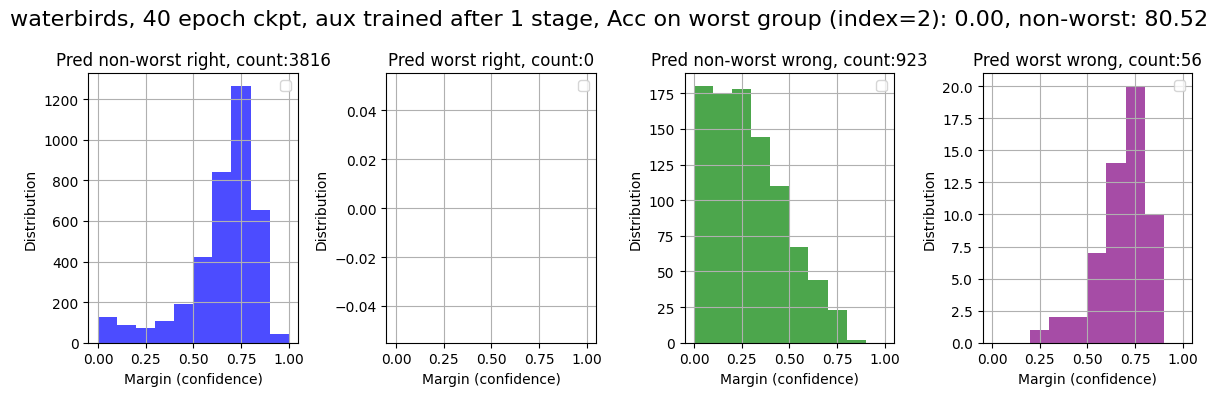

majority [0, 3]
conflict, worst [1, 2]


/home/anmolreddy/.local/lib/python3.7/site-packages/ipykernel_launcher.py:77: RuntimeWarning: invalid value encountered in true_divide


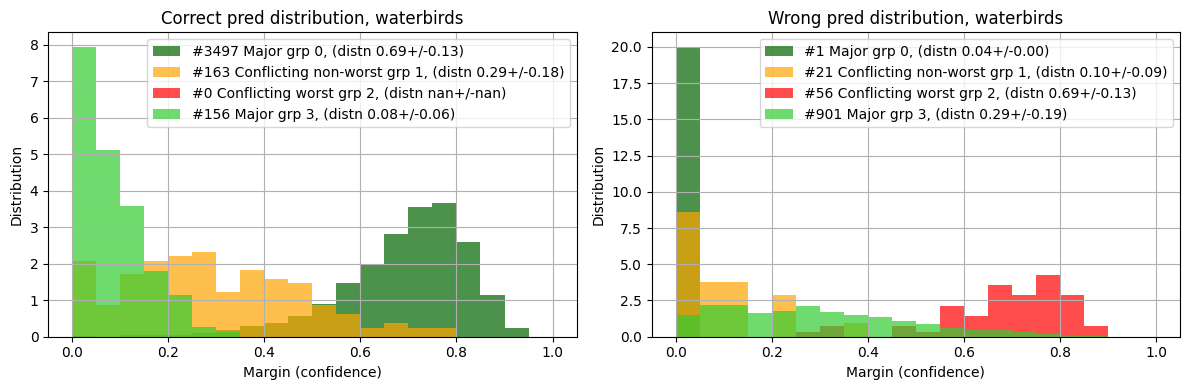

In [25]:
plot_dataset('waterbirds', epoch=40, feature_level=1)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


group 0, correct 3498, wrong 0
group 1, correct 184, wrong 0
group 2, correct 56, wrong 0
group 3, correct 1057, wrong 0
recall: 0.00


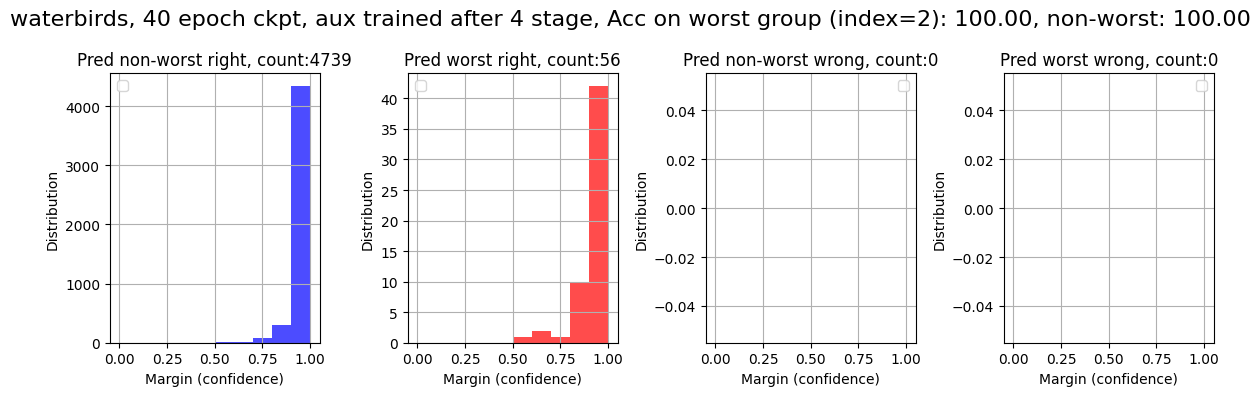

majority [0, 3]
conflict, worst [1, 2]


/home/anmolreddy/.local/lib/python3.7/site-packages/ipykernel_launcher.py:85: RuntimeWarning: invalid value encountered in true_divide


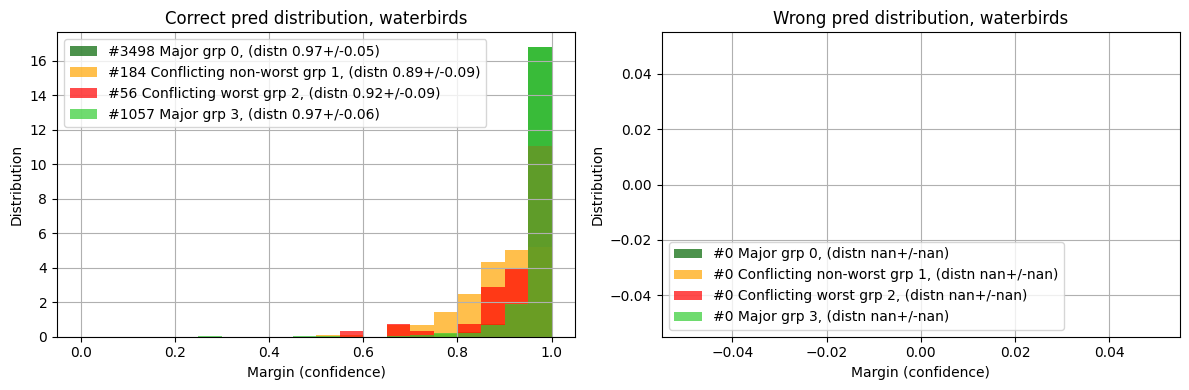

In [27]:
plot_dataset('waterbirds', epoch=40, feature_level=4)

group 0, correct 3497, wrong 1
group 1, correct 163, wrong 21
group 2, correct 0, wrong 56
group 3, correct 159, wrong 898
recall: 100.00


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


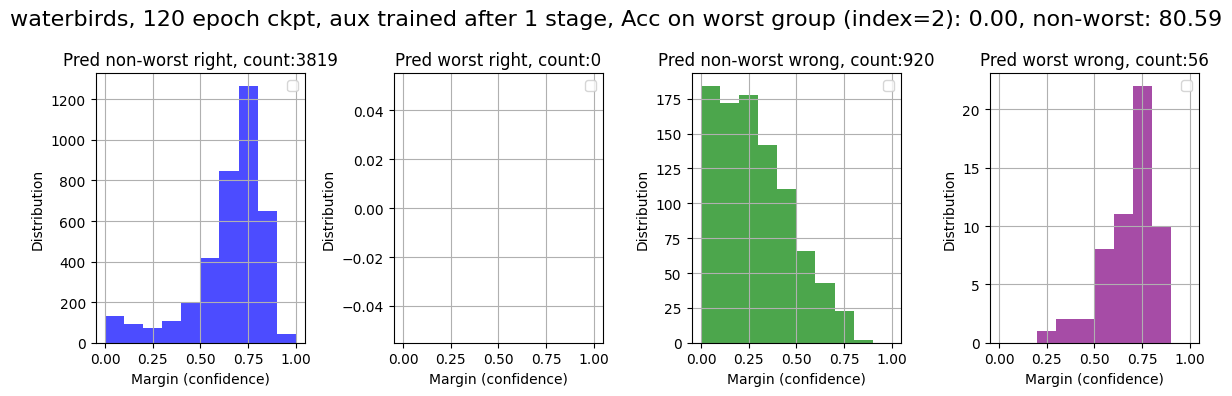

majority [0, 3]
conflict, worst [1, 2]


/home/anmolreddy/.local/lib/python3.7/site-packages/ipykernel_launcher.py:77: RuntimeWarning: invalid value encountered in true_divide


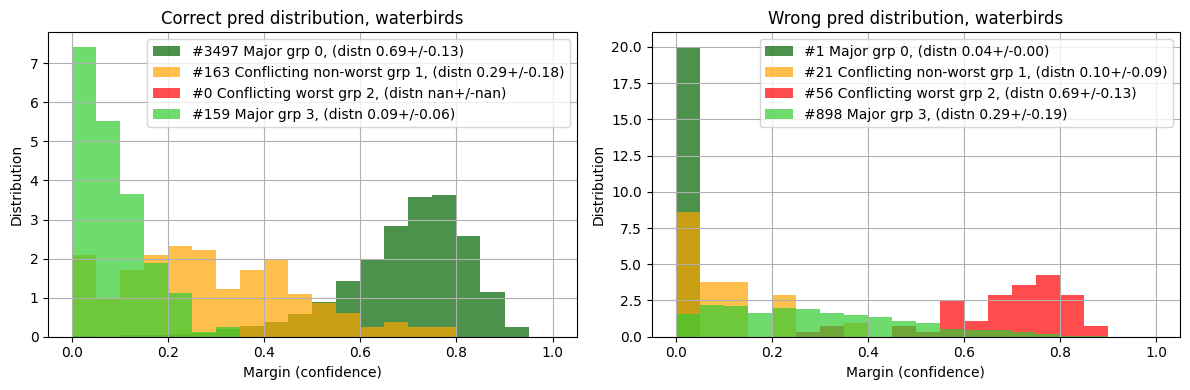

In [28]:
plot_dataset('waterbirds', epoch=120, feature_level=1)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


group 0, correct 3498, wrong 0
group 1, correct 184, wrong 0
group 2, correct 56, wrong 0
group 3, correct 1057, wrong 0
recall: 0.00


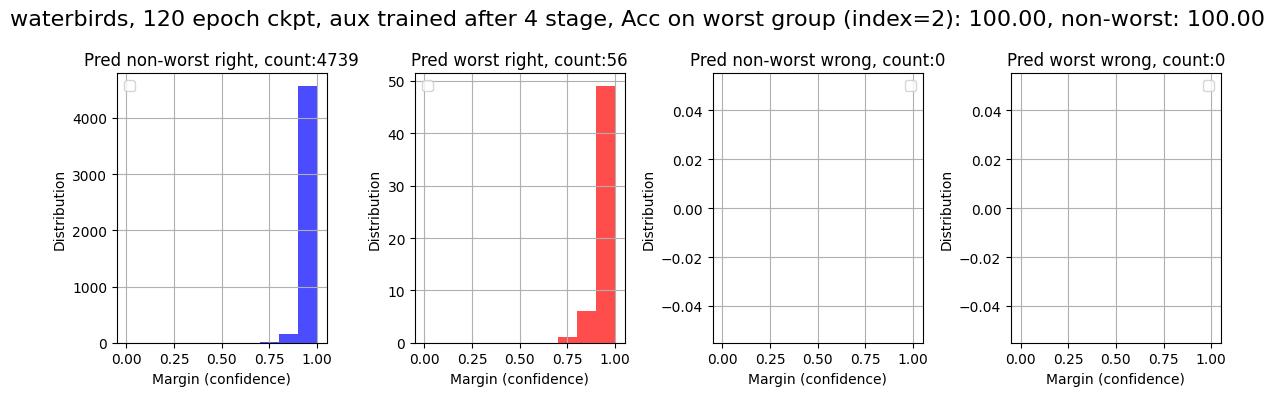

majority [0, 3]
conflict, worst [1, 2]


/home/anmolreddy/.local/lib/python3.7/site-packages/ipykernel_launcher.py:85: RuntimeWarning: invalid value encountered in true_divide


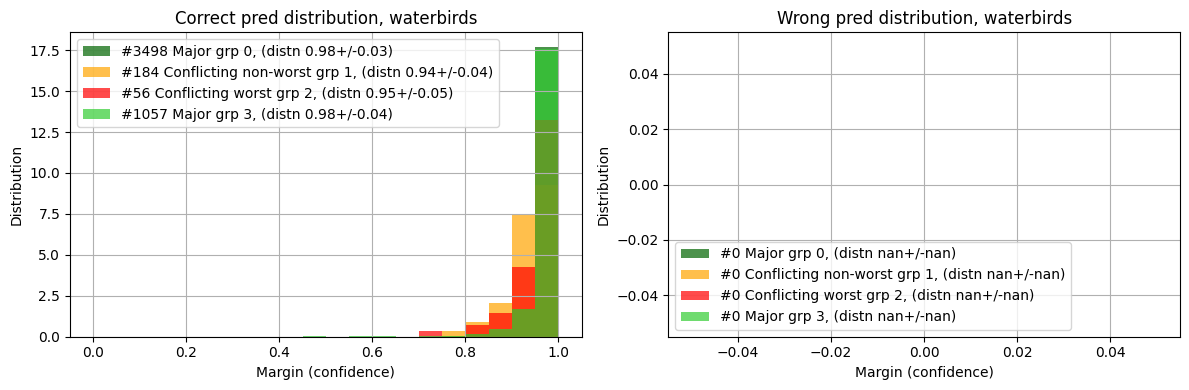

In [29]:
plot_dataset('waterbirds', epoch=120, feature_level=4)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


group 0, correct 3497, wrong 1
group 1, correct 163, wrong 21
group 2, correct 0, wrong 56
group 3, correct 160, wrong 897
recall: 100.00


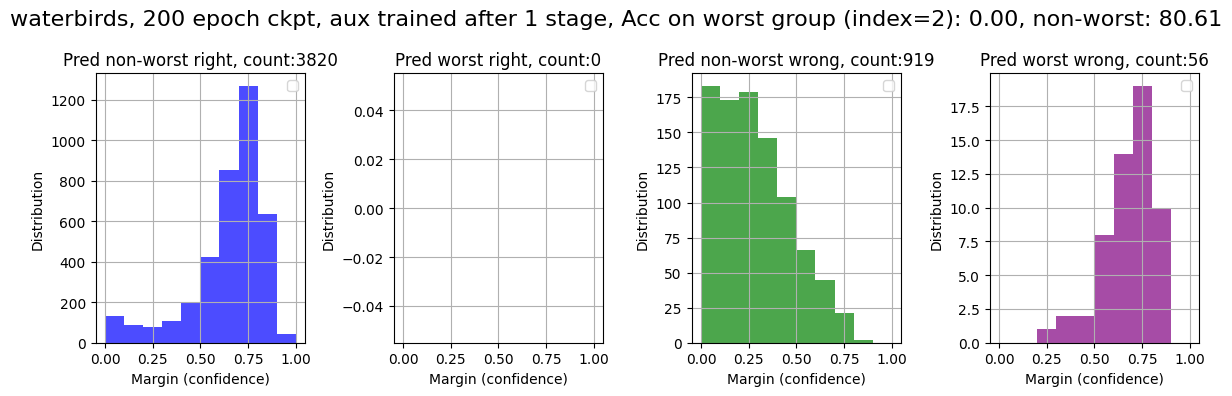

majority [0, 3]
conflict, worst [1, 2]


/home/anmolreddy/.local/lib/python3.7/site-packages/ipykernel_launcher.py:77: RuntimeWarning: invalid value encountered in true_divide


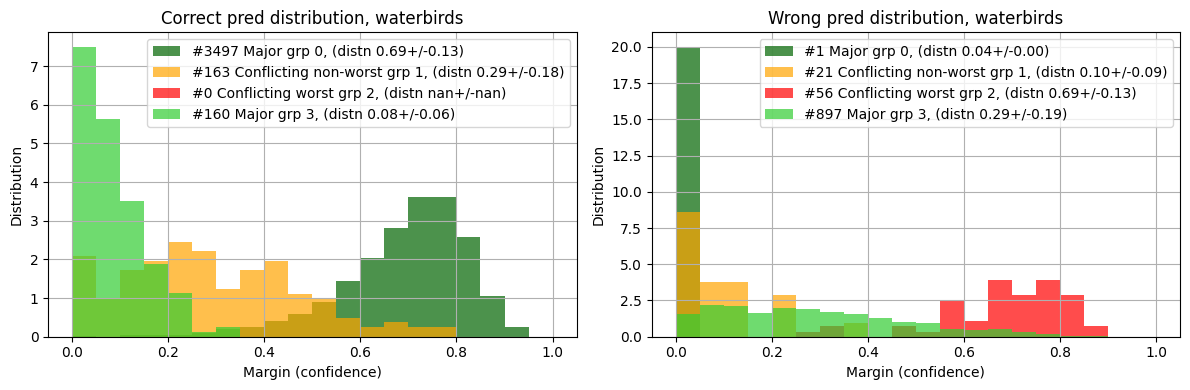

In [30]:
plot_dataset('waterbirds', epoch=200, feature_level=1)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


group 0, correct 71629, wrong 0
group 1, correct 66874, wrong 0
group 2, correct 47, wrong 22833
group 3, correct 0, wrong 1387
recall: 100.00


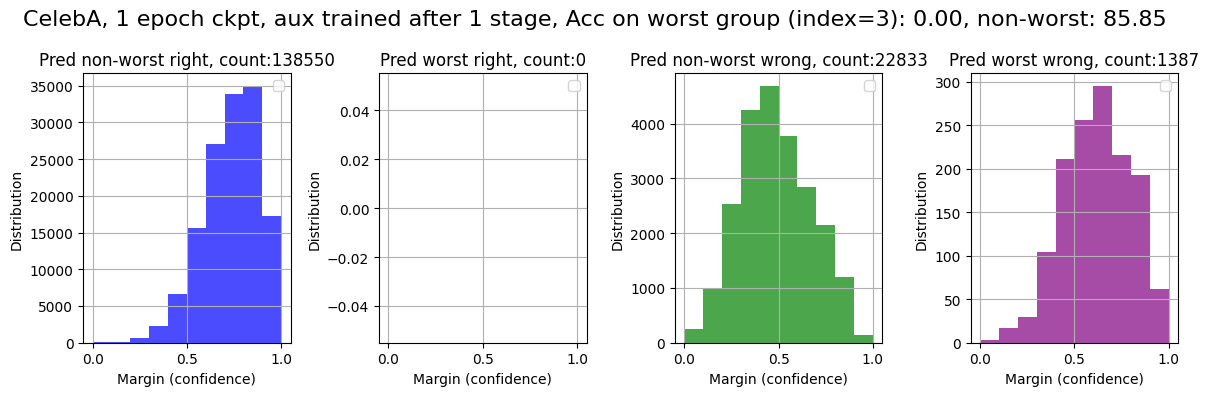

majority [0, 1]
conflict, worst [2, 3]


/home/anmolreddy/.local/lib/python3.7/site-packages/ipykernel_launcher.py:85: RuntimeWarning: invalid value encountered in true_divide
/home/anmolreddy/.local/lib/python3.7/site-packages/ipykernel_launcher.py:77: RuntimeWarning: invalid value encountered in true_divide


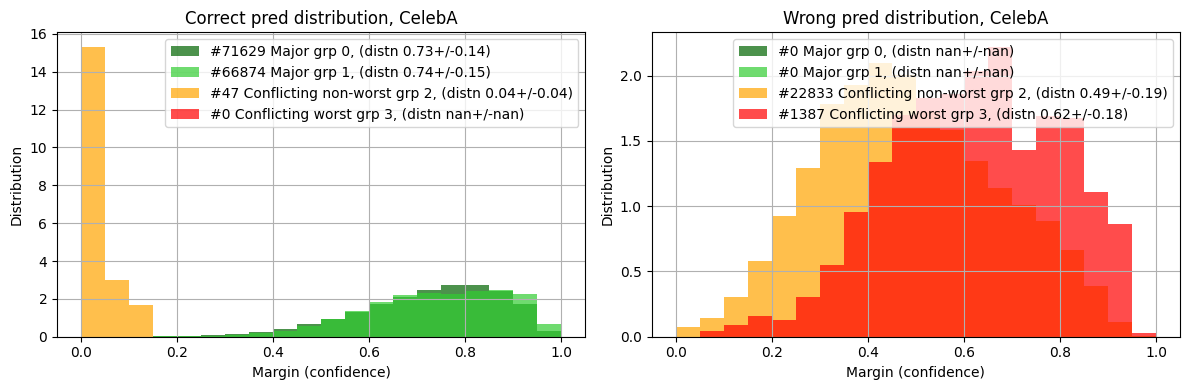

In [47]:
dataset, epoch, feature_level = 'CelebA', 1, 1
args = dataset, epoch, feature_level
result = get_margin_details(*args)
plot(*result, *args)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


group 0, correct 68578, wrong 3051
group 1, correct 66545, wrong 329
group 2, correct 18952, wrong 3928
group 3, correct 438, wrong 949
recall: 68.42


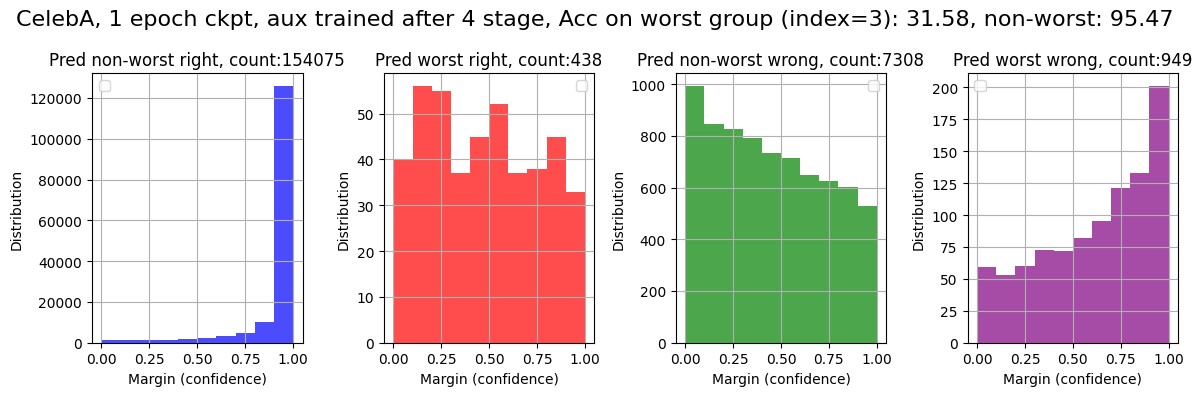

majority [0, 1]
conflict, worst [2, 3]


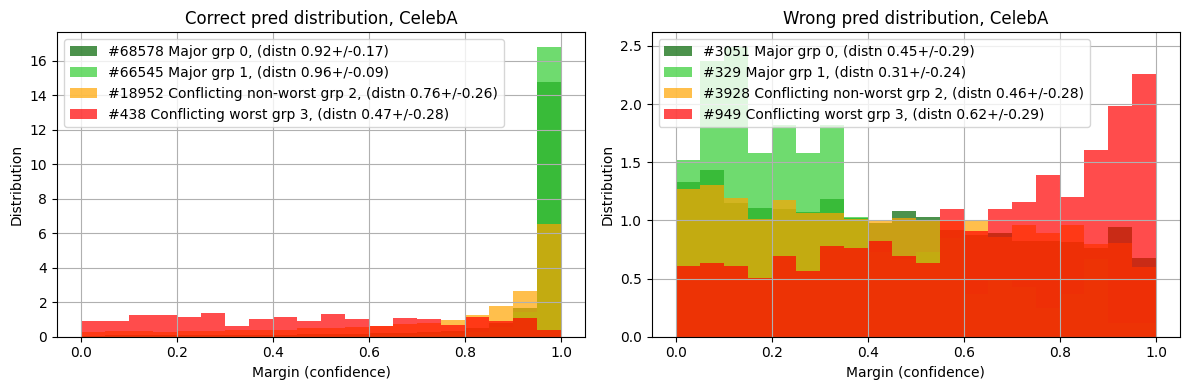

In [46]:
dataset, epoch, feature_level = 'CelebA', 1, 4
args = dataset, epoch, feature_level
result = get_margin_details(*args)
plot(*result, *args)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


group 0, correct 71616, wrong 13
group 1, correct 66871, wrong 3
group 2, correct 232, wrong 22648
group 3, correct 1, wrong 1386
recall: 99.93


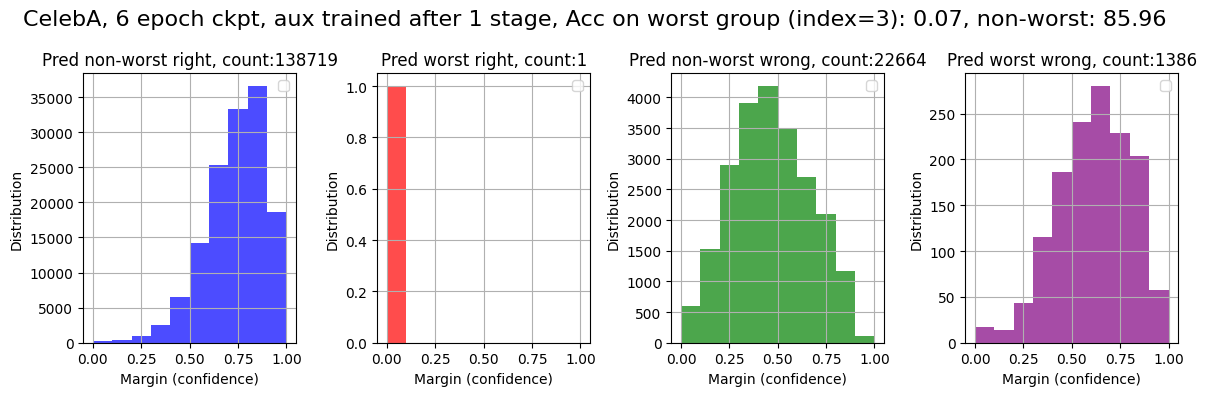

majority [0, 1]
conflict, worst [2, 3]


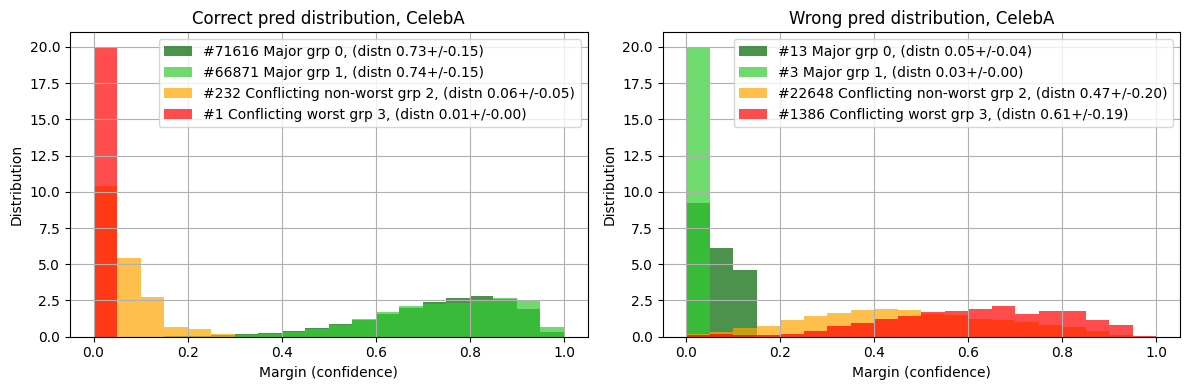

In [45]:
dataset, epoch, feature_level = 'CelebA', 6, 1
args = dataset, epoch, feature_level
result = get_margin_details(*args)
plot(*result, *args)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


group 0, correct 68844, wrong 2785
group 1, correct 66574, wrong 300
group 2, correct 19579, wrong 3301
group 3, correct 545, wrong 842
recall: 60.71


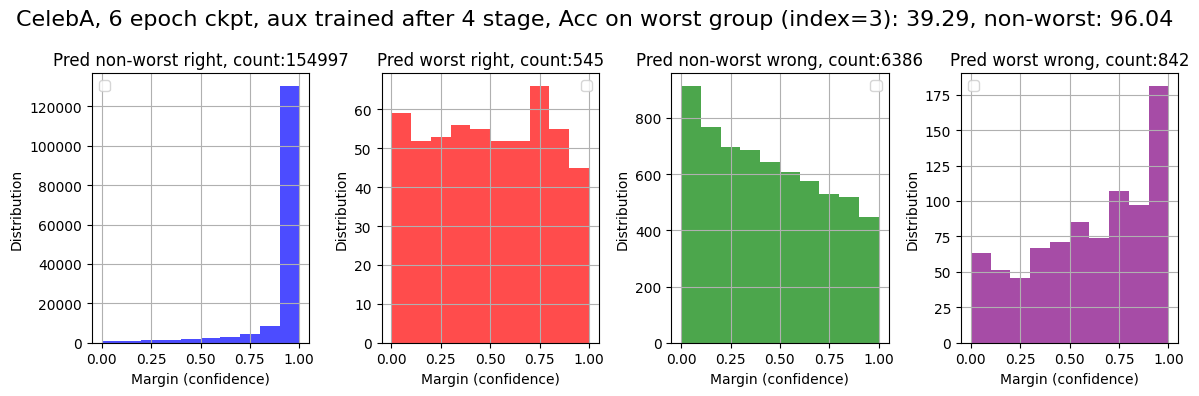

majority [0, 1]
conflict, worst [2, 3]


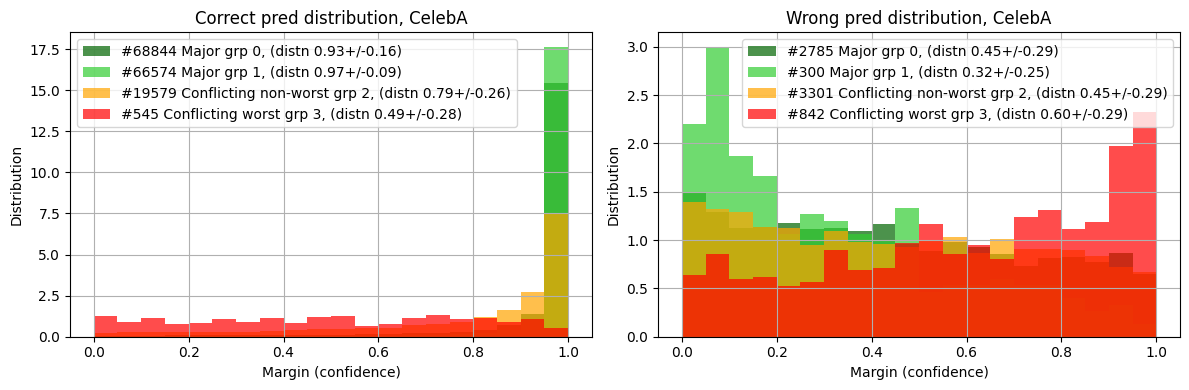

In [44]:
dataset, epoch, feature_level = 'CelebA', 6, 4
args = dataset, epoch, feature_level
result = get_margin_details(*args)
plot(*result, *args)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


group 0, correct 71601, wrong 28
group 1, correct 66856, wrong 18
group 2, correct 350, wrong 22530
group 3, correct 5, wrong 1382
recall: 99.64


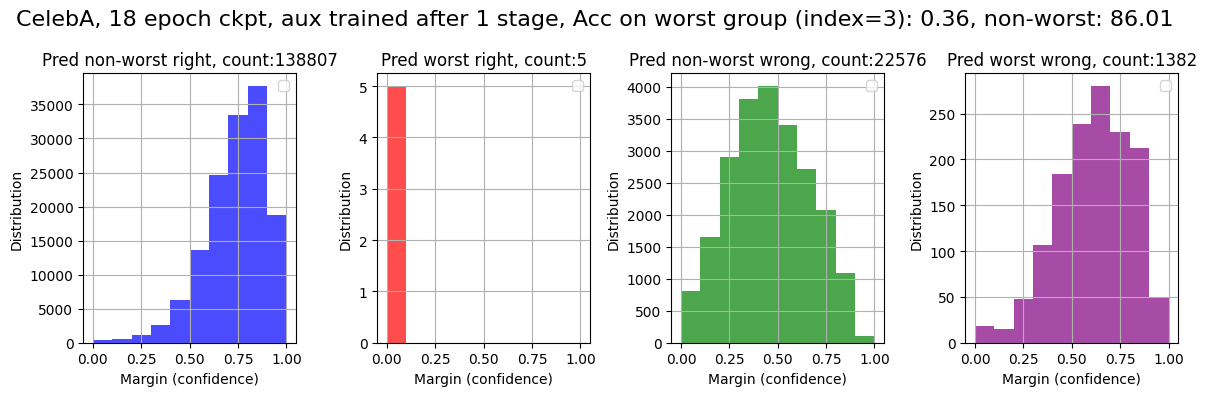

majority [0, 1]
conflict, worst [2, 3]


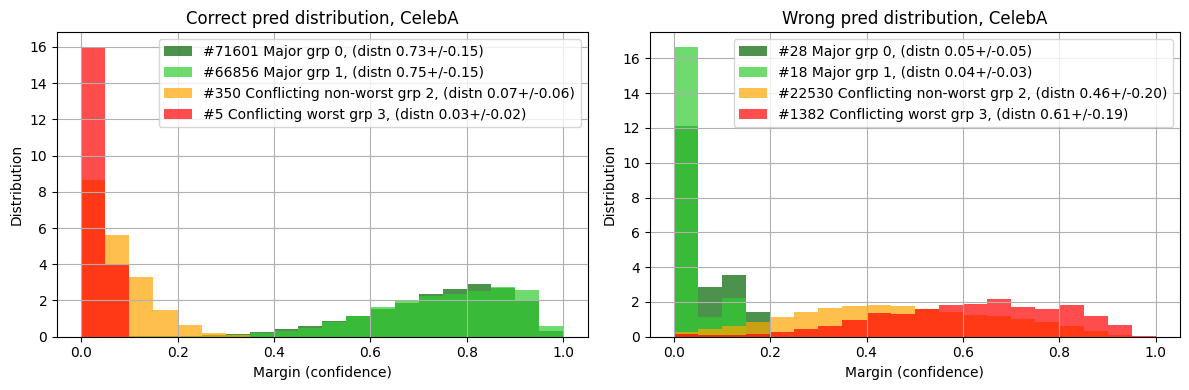

In [43]:
dataset, epoch, feature_level = 'CelebA', 18, 1
args = dataset, epoch, feature_level
result = get_margin_details(*args)
plot(*result, *args)

group 0, correct 71619, wrong 10
group 1, correct 66871, wrong 3
group 2, correct 222, wrong 22658
group 3, correct 1, wrong 1386
recall: 99.93


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


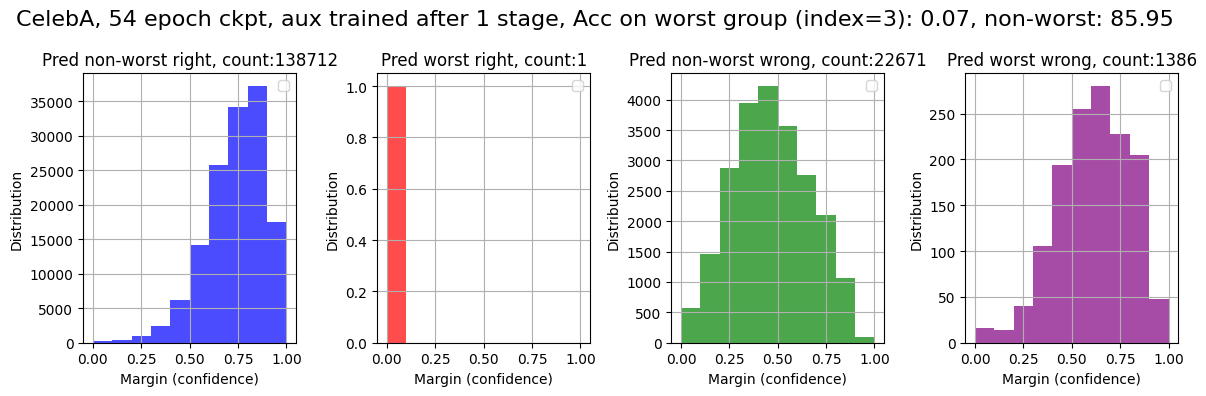

majority [0, 1]
conflict, worst [2, 3]


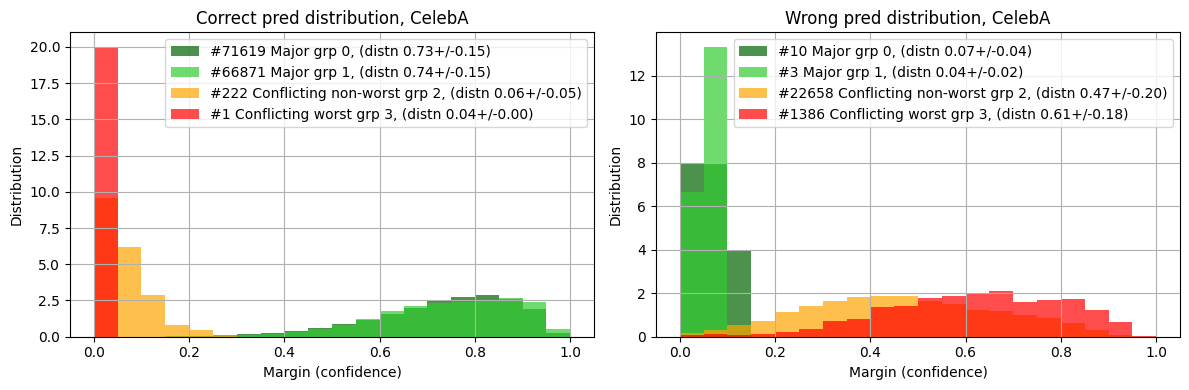

In [42]:
dataset, epoch, feature_level = 'CelebA', 54, 1
args = dataset, epoch, feature_level
result = get_margin_details(*args)
plot(*result, *args)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


group 0, correct 71059, wrong 570
group 1, correct 66831, wrong 43
group 2, correct 22167, wrong 713
group 3, correct 1113, wrong 274
recall: 19.75


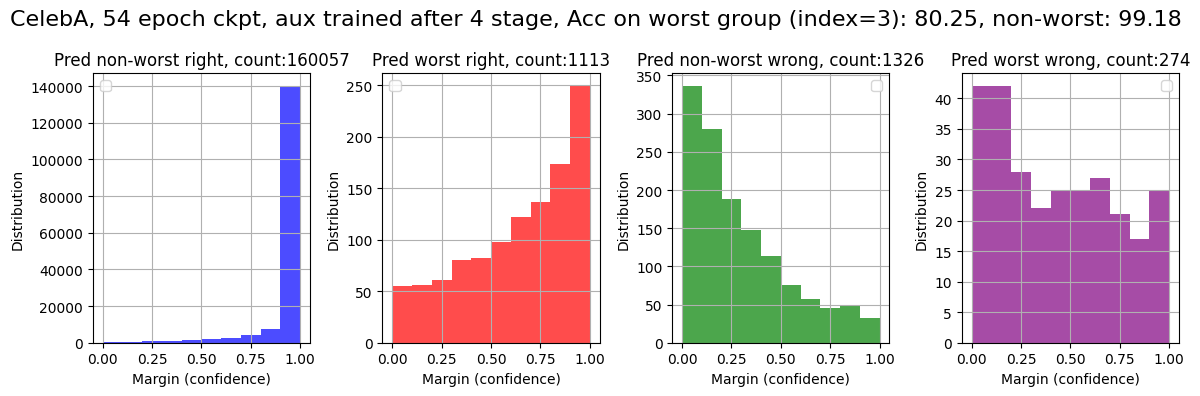

majority [0, 1]
conflict, worst [2, 3]


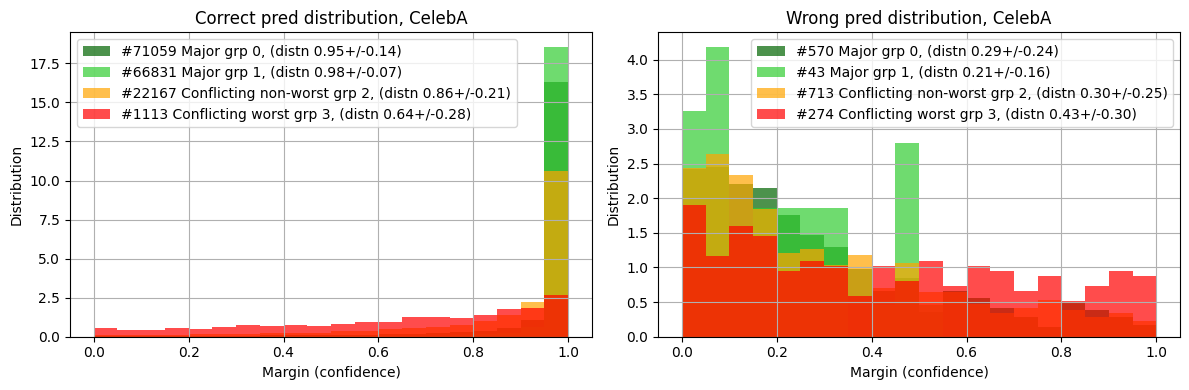

In [41]:
dataset, epoch, feature_level = 'CelebA', 54, 4
args = dataset, epoch, feature_level
result = get_margin_details(*args)
plot(*result, *args)

In [ ]:
model = get_model('resnet18')
model.fc = nn.Linear(model.fc.in_features, 2)
model.load_state_dict(torch.load(os.path.join(f'./results/CUB/resnet18-pt_0/', f'0_ckpt.pth.tar'))['model'])
learning_rate, widx, epochs = 1e-3, 2, 8

loader_kwargs = {'batch_size':10, 'num_workers':4, 'pin_memory':True}
with open(os.path.join('results', 'CUB', 'waterbird_complete95_forest2water2_dataset_0.pkl'), 'rb') as file:
    data = pickle.load(file)
    train_data = data['train_data']
    train_loader = get_loader(train_data, train=True, **loader_kwargs)
loader_kwargs = {'batch_size':64, 'num_workers':4, 'pin_memory':True}
n = len(train_data)
train_data, test_data = random_split(train_data, [n//2, n-n//2])
train_loader, test_loader = get_loader(train_data, train=True, **loader_kwargs), \
                            get_loader(test_data, train=False, **loader_kwargs)
    
model = model.to(device='cuda')
for _, param in model.named_parameters():
    param.requires_grad = False
feature_level = 2
# converter = model._make_layer(BasicBlock, 64 * 2**feature_level, 0)
converter = BasicBlock(32 * 2**feature_level, 64 * 2**feature_level, stride=1).to(device='cuda')
model = FeatResNet(model, feature_level).to(device='cuda')

samples = next(iter(train_loader))
sample_inputs = samples[0].to(device='cuda')

features = model(sample_inputs)
features = converter(features)
print(converter)
d = torch.flatten(nn.AdaptiveAvgPool2d((1, 1))(features), 1).shape[1]
projector = Projector(d, converter).to(device='cuda')
print(projector(model(sample_inputs)).shape)

In [ ]:

# d = torch.flatten(nn.AdaptiveAvgPool2d((1, 1))(features), 1).shape[1]
# projector = Projector(d).to(device='cuda')
projector.train()

optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, projector.parameters()), 
                            lr=learning_rate, momentum=0.9, weight_decay=5e-4)
train(model, projector, optimizer, train_loader, num_epochs=epochs)
# yhat, correct, worst = infer(model, projector, test_loader, widx=widx)